# **0. *Project Info***
- owner: Erwin Gunawan | erwingun03@gmail.com
- Goals: Recommender System
- DataSet: https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset

# **1. *Library Setup***

In [2]:
!pip install langdetect
!pip install wordcloud
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=11f4198f4c6f7a0b158c56e02f82457d39d93e7b5150d3d430b49bdb6db8c484
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud
from langdetect import detect
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras import backend as K


from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter


# **2. *Data Loading***

in this part data loaded from drive. There are 3 data file that loaded:
- user score data
- user details data
- anime details data

In [4]:
"""
DOWNLOADING Bank Transaction Dataset
"""
! gdown 1c1Y8vkot86g3cQAr4pYJ_8viX5uVpZ7-
! gdown 1KpYNQeoRhRduzIf70lZ0CPextK6zCdsy
! gdown 1MWtl0Ap4s-H7YB-Tt6ZT_8wyGPKOm22h

Downloading...
From: https://drive.google.com/uc?id=1c1Y8vkot86g3cQAr4pYJ_8viX5uVpZ7-
To: /content/anime-dataset-2023.csv
100% 15.9M/15.9M [00:00<00:00, 30.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KpYNQeoRhRduzIf70lZ0CPextK6zCdsy
To: /content/users-details-2023.csv
100% 73.9M/73.9M [00:00<00:00, 75.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1MWtl0Ap4s-H7YB-Tt6ZT_8wyGPKOm22h
From (redirected): https://drive.google.com/uc?id=1MWtl0Ap4s-H7YB-Tt6ZT_8wyGPKOm22h&confirm=t&uuid=5a46ea57-0afb-4c82-b224-565dc330259a
To: /content/users-score-2023.csv
100% 1.16G/1.16G [00:17<00:00, 66.1MB/s]


In [5]:
"""
Load User Score Data
"""
df_score = pd.read_csv('/content/users-score-2023.csv')
df_score.head(5)

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


In [6]:
"""
Load User Detail Data
"""
df_user = pd.read_csv('/content/users-details-2023.csv')
df_user.head(5)

,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
0,1,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,8.0,93.0,64.0,399.0,60.0,8458.0
1,3,Aokaado,Male,NaN,"Oslo, Norway",2004-11-11T00:00:00+00:00,68.6,7.34,23.0,137.0,99.0,44.0,40.0,343.0,15.0,4072.0
2,4,Crystal,Female,NaN,"Melbourne, Australia",2004-11-13T00:00:00+00:00,212.8,6.68,16.0,636.0,303.0,0.0,45.0,1000.0,10.0,12781.0
3,9,Arcane,NaN,NaN,NaN,2004-12-05T00:00:00+00:00,30.0,7.71,5.0,54.0,4.0,3.0,0.0,66.0,0.0,1817.0
4,18,Mad,NaN,NaN,NaN,2005-01-03T00:00:00+00:00,52.0,6.27,1.0,114.0,10.0,5.0,23.0,153.0,42.0,3038.0


In [7]:
"""
Load Anime Detail Data
"""
df_anime = pd.read_csv('/content/anime-dataset-2023.csv')
df_anime.head(5)

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


# **3. *Data Understanding***

In [ ]:
print("User Score Data:")
print(df_score.info())
print("-" * 80)
print("User Detail Data:")
print(df_user.info())
print("-" * 80)
print("Anime Detail Data:")
print(df_anime.info())
print("-" * 80)

User Score Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB
None
--------------------------------------------------------------------------------
User Detail Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731290 entries, 0 to 731289
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Mal ID            731290 non-null  int64  
 1   Username          731289 non-null  object 
 2   Gender            224383 non-null  object 
 3   Birthday          168068 non-null  object 
 4   Location          152805 non-null  object 
 5   Joined            731290 non-null  object 
 6   Days Watched      731282 non-null  flo

In [ ]:
"""
Check for duplicates, missing values, and nan values
"""
def check_all_data(df_score, df_user, df_anime):
  duplicates_score = df_score.duplicated().sum()
  duplicates_user = df_user.duplicated().sum()
  duplicates_anime = df_anime.duplicated().sum()

  missing_values_score = df_score.isnull().sum().sum()
  missing_values_user = df_user.isnull().sum().sum()
  missing_values_anime = df_anime.isnull().sum().sum()

  nan_values_score = df_score.isna().sum().sum()
  nan_values_user = df_user.isna().sum().sum()
  nan_values_anime = df_anime.isna().sum().sum()

  if duplicates_score == 0 and duplicates_user == 0 and duplicates_anime == 0 and \
    missing_values_score == 0 and missing_values_user == 0 and missing_values_anime == 0 and \
    nan_values_score == 0 and nan_values_user == 0 and nan_values_anime == 0:
      print("The data is clean.")
  else:
      print("The data has issues:")
      if duplicates_score > 0:
          print(f"There are {duplicates_score} duplicate rows in df_score.")
      if duplicates_user > 0:
          print(f"There are {duplicates_user} duplicate rows in df_user.")
      if duplicates_anime > 0:
          print(f"There are {duplicates_anime} duplicate rows in df_anime.")

      if missing_values_score > 0:
          print(f"There are {missing_values_score} missing values in df_score.")
      if missing_values_user > 0:
          print(f"There are {missing_values_user} missing values in df_user.")
      if missing_values_anime > 0:
          print(f"There are {missing_values_anime} missing values in df_anime.")

      if nan_values_score > 0:
          print(f"There are {nan_values_score} NaN values in df_score.")
      if nan_values_user > 0:
          print(f"There are {nan_values_user} NaN values in df_user.")
      if nan_values_anime > 0:
          print(f"There are {nan_values_anime} NaN values in df_anime.")

In [ ]:
check_all_data(df_score, df_user, df_anime)

The data has issues:
There are 232 missing values in df_score.
There are 1648695 missing values in df_user.
There are 232 NaN values in df_score.
There are 1648695 NaN values in df_user.


## 3.1 *Exploratory Data Analysis* (EDA)

### 3.1.1 *Univariate Analysis*

In [ ]:
"""
User Score Data Rating analysis
"""
df_score['rating'].describe()

,rating
count,2.432519e+07
mean,7.622930e+00
std,1.661510e+00
min,1.000000e+00
25%,7.000000e+00
50%,8.000000e+00
75%,9.000000e+00
max,1.000000e+01


<ipython-input-30-05c2f2c03edd>:8: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



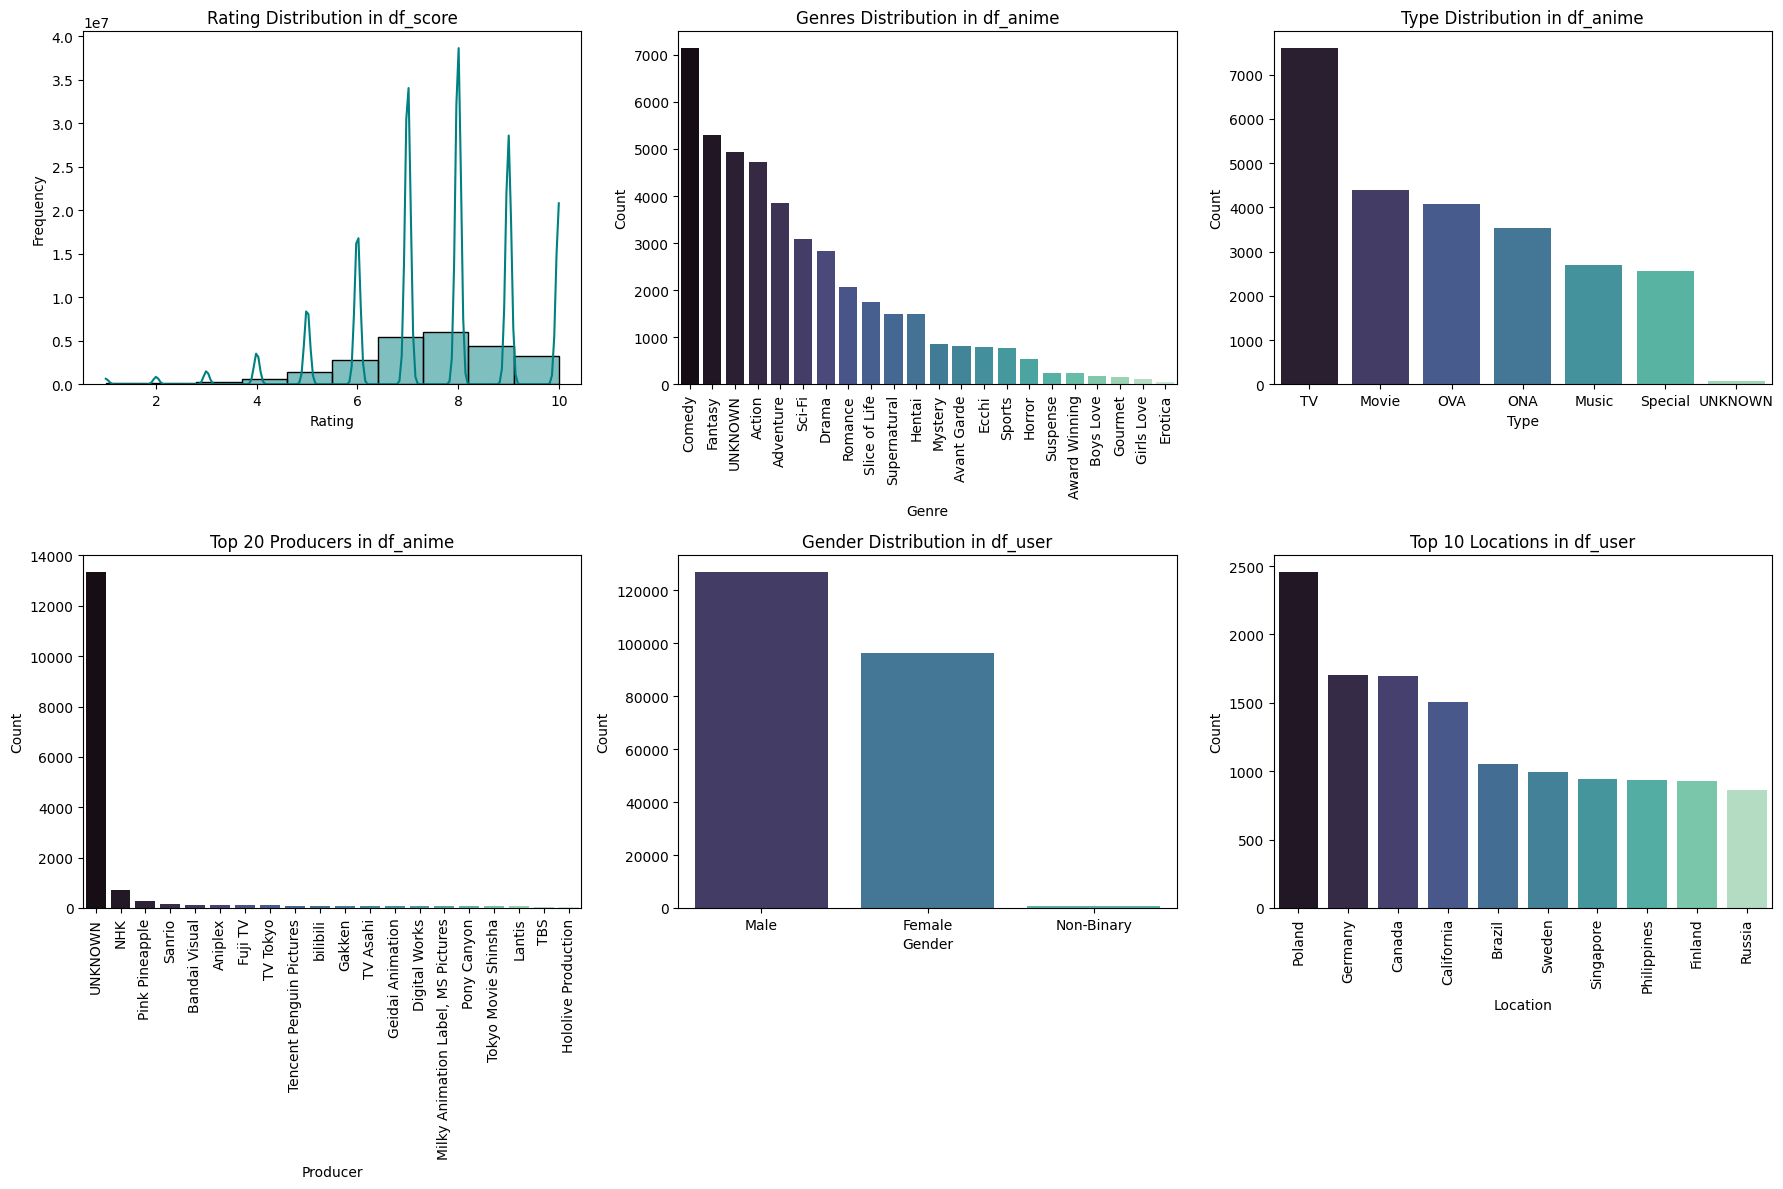

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Rating Distribution in df_score
sns.histplot(df_score['rating'], bins=10, kde=True, color='teal', palette='mako', ax=axes[0, 0])
axes[0, 0].set_title('Rating Distribution in df_score')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')

# 2. Genre Distribution in df_anime
genres_split = df_anime['Genres'].str.split(', ', expand=True).stack()
genres_count = genres_split.value_counts()
sns.barplot(x=genres_count.index, y=genres_count.values, hue=genres_count.index, ax=axes[0, 1], palette='mako')
axes[0, 1].set_title('Genres Distribution in df_anime')
axes[0, 1].set_xlabel('Genre')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=90)

# 3. Anime Type Distribution in df_anime
type_count = df_anime['Type'].value_counts()
sns.barplot(x=type_count.index, y=type_count.values, hue=type_count.index, ax=axes[0, 2], palette='mako')
axes[0, 2].set_title('Type Distribution in df_anime')
axes[0, 2].set_xlabel('Type')
axes[0, 2].set_ylabel('Count')

# 4. Producers Distribution in df_anime (Top 20)
producers_count = df_anime['Producers'].value_counts().head(20)
sns.barplot(x=producers_count.index, y=producers_count.values, hue=producers_count.index, ax=axes[1, 0], palette='mako')
axes[1, 0].set_title('Top 20 Producers in df_anime')
axes[1, 0].set_xlabel('Producer')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=90)

# 5. Gender Distribution in df_user
gender_count = df_user['Gender'].value_counts()
sns.barplot(x=gender_count.index, y=gender_count.values, hue=gender_count.index, ax=axes[1, 1], palette='mako')
axes[1, 1].set_title('Gender Distribution in df_user')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Count')

# 6. Location Distribution in df_user (Top 10)
location_count = df_user['Location'].value_counts().head(10)
sns.barplot(x=location_count.index, y=location_count.values, hue=location_count.index, ax=axes[1, 2], palette='mako')
axes[1, 2].set_title('Top 10 Locations in df_user')
axes[1, 2].set_xlabel('Location')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### 3.1.2 *Multivariate Analysis*

<ipython-input-21-953a20fe00ed>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




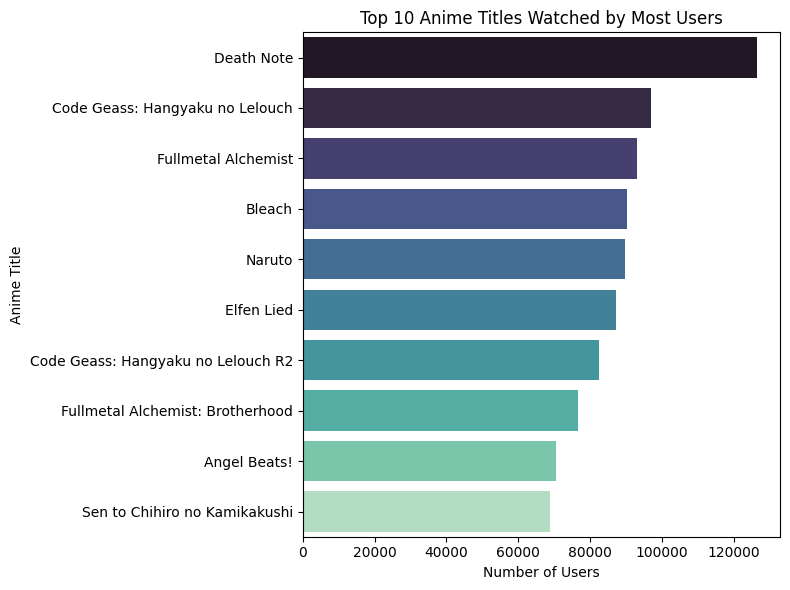

In [ ]:
anime_watch_count = df_score.groupby('Anime Title')['user_id'].nunique().reset_index()
anime_watch_count = anime_watch_count.rename(columns={'user_id': 'User Count'})
anime_watch_count = anime_watch_count.sort_values(by='User Count', ascending=False)
top_anime_watch_count = anime_watch_count.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x='User Count', y='Anime Title', data=top_anime_watch_count, palette='mako')
plt.title('Top 10 Anime Titles Watched by Most Users')
plt.xlabel('Number of Users')
plt.ylabel('Anime Title')
plt.tight_layout()
plt.show()

<ipython-input-25-a832d9897587>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




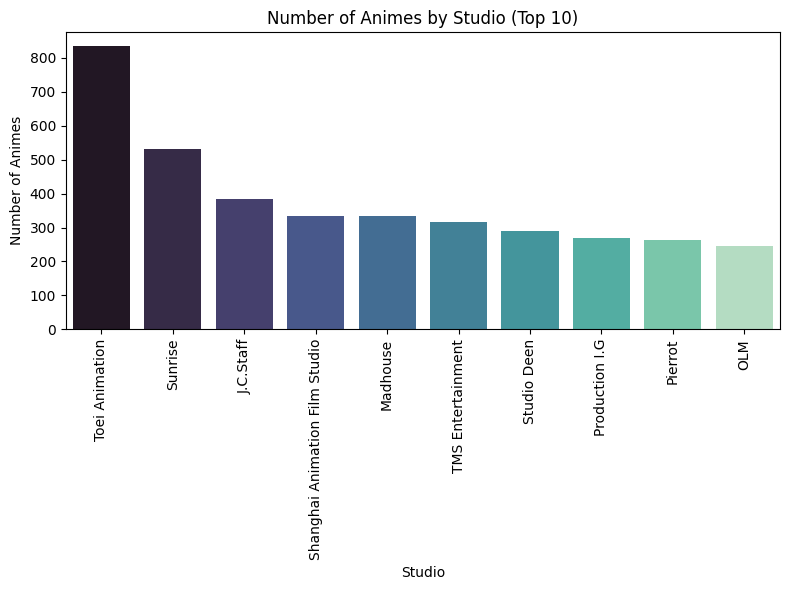

In [ ]:
studio_counts = df_anime['Studios'].value_counts()
studio_counts = studio_counts[studio_counts.index != 'UNKNOWN']
top_studios = studio_counts.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_studios.index, y=top_studios.values, palette='mako')
plt.title('Number of Animes by Studio (Top 10)')
plt.xlabel('Studio')
plt.ylabel('Number of Animes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

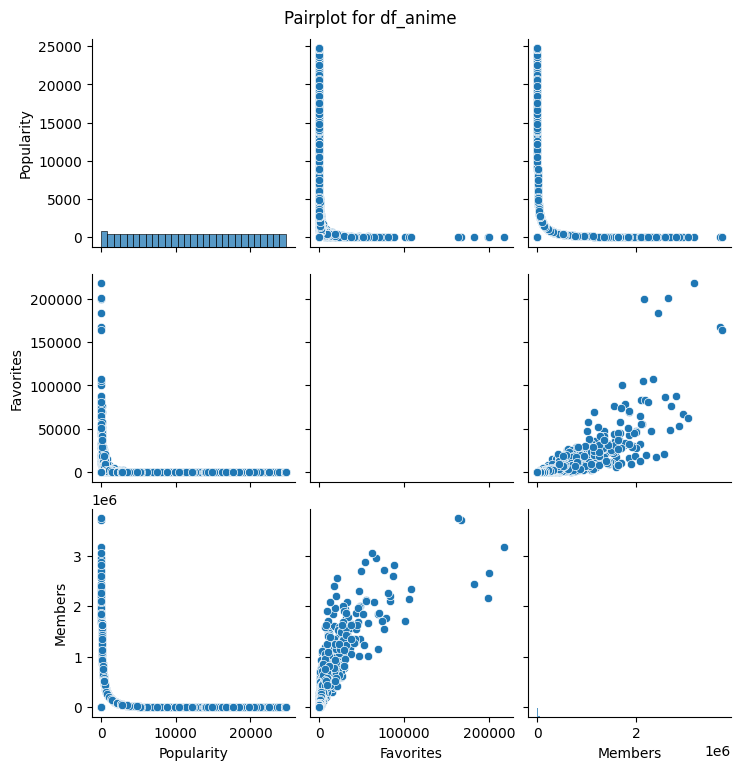

In [ ]:
df_anime_filtered = df_anime.drop(columns=['Image URL', 'Aired', 'Premiered', 'anime_id', 'English name', 'Other name'])

df_anime_filtered = df_anime_filtered.select_dtypes(include=[np.number])

sns.pairplot(df_anime_filtered)
plt.suptitle('Pairplot for df_anime', y=1.02)
plt.show()

In [ ]:
categorical_columns = ['Studios', 'Genres', 'Type']

ordinal_encoder = OrdinalEncoder()
df_anime[categorical_columns] = ordinal_encoder.fit_transform(df_anime[categorical_columns])

print(df_anime.head())

   anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name Score  Genres  \
0                         カウボーイビバップ  8.75   146.0   
1                    カウボーイビバップ 天国の扉  8.38   343.0   
2                             トライガン  8.22   113.0   
3  Witch Hunter ROBIN (ウイッチハンターロビン)  7.25   261.0   
4                            冒険王ビィト  6.94   492.0   

                                            Synopsis  Type Episodes  \
0  Crime is timeless. By the year 2071, humanity ...   5.0     26.0   
1  Another day, another bounty—such is the life o...   0.0      1.0   
2  Vash the Stampede is the m

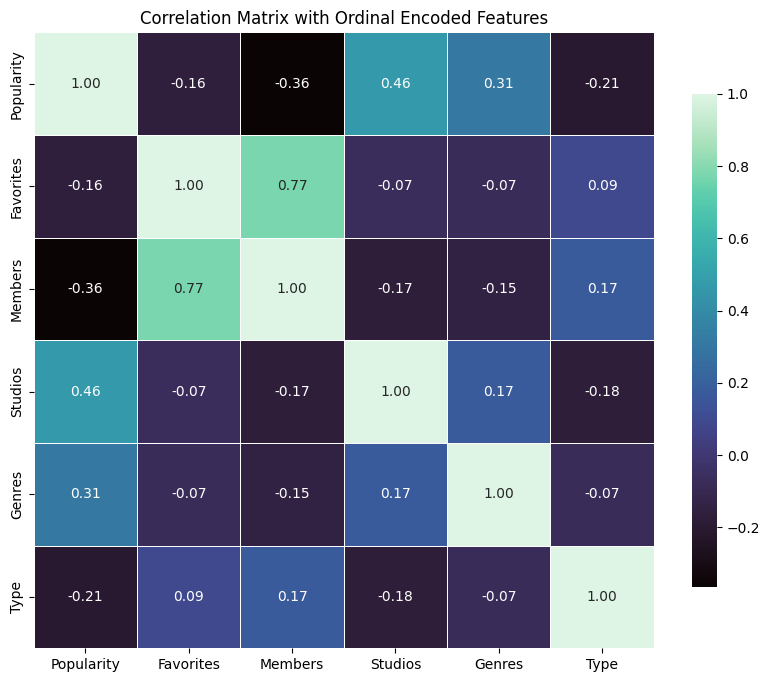

In [ ]:
correlation_matrix = df_anime[['Popularity', 'Favorites', 'Members', 'Studios', 'Genres', 'Type']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='mako', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix with Ordinal Encoded Features')
plt.show()

# **4. *Data Preparation***

In [ ]:
unique_ratings = df_score['rating'].unique()
print(unique_ratings)
print("-" * 80)
unique_Genres = df_anime['Genres'].unique() #Already convert to numerical feature
print(unique_Genres)
print("-" * 80)
unique_Studios = df_anime['Studios'].unique() #Already convert to numerical feature
print(unique_Studios)
print("-" * 80)

[ 9  7  5  8  6  4 10  3  2  1]
--------------------------------------------------------------------------------
[146. 343. 113. ... 927. 166.  84.]
--------------------------------------------------------------------------------
[1247.  179.  648. ...  450.  232. 1492.]
--------------------------------------------------------------------------------


In [ ]:
missing_values = df_user.isnull().sum()
features_with_missing = missing_values[missing_values > 0]
print("Features with missing values and NaNs in df_user:")
print(features_with_missing)

Features with missing values and NaNs in df_user:
Username                 1
Gender              506907
Birthday            563222
Location            578485
Days Watched             8
Mean Score               8
Watching                 8
Completed                8
On Hold                  8
Dropped                  8
Plan to Watch            8
Total Entries            8
Rewatched                8
Episodes Watched         8
dtype: int64


In [ ]:
missing_values = df_score.isnull().sum()
features_with_missing = missing_values[missing_values > 0]
print("Features with missing values and NaNs in df_score:")
print(features_with_missing)

Features with missing values and NaNs in df_score:
Username    232
dtype: int64


In [8]:
"""
After knowing alot of thing in EDA.
in this part of data preparation i suggest to:
1. Remove 'Unknown' genres, and Type from df_anime

2. removing missing value / fill it, the data that we have:
There are 232 missing values in df_score.
There are 1648695 missing values in df_user.
There are 232 NaN values in df_score.
There are 1648695 NaN values in df_user.
"""
# Handle UNKNOW VALUE
df_anime_cleaned = df_anime[df_anime['Genres'] != 'Unknown']
df_anime_cleaned = df_anime_cleaned[df_anime_cleaned['Type'] != 'Unknown']

# Handle MISSING VALUE
df_user_cleaned = df_user.drop(columns=['Gender', 'Birthday', 'Location'])
columns_to_impute = ['Days Watched', 'Mean Score', 'Watching', 'Completed',
                     'On Hold', 'Dropped', 'Plan to Watch', 'Total Entries',
                     'Rewatched', 'Episodes Watched']
for col in columns_to_impute:
    df_user_cleaned[col].fillna(df_user_cleaned[col].median(), inplace=True)

df_score_cleaned = df_score.dropna(subset=['Username'])

<ipython-input-8-95330a395d6d>:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
check_all_data(df_score_cleaned, df_user_cleaned, df_anime_cleaned)

The data has issues:
There are 1 missing values in df_user.
There are 1 NaN values in df_user.


a lot better...

In [9]:
"""
Scaling our "rating" column by creating  a MinMaxScaler object
Scale the 'score' column between 0 and 1

also Encoding user IDs and anime IDs
"""
scaler = MinMaxScaler(feature_range=(0, 1))

df_score_cleaned['scaled_score'] = scaler.fit_transform(df_score_cleaned[['rating']])

user_encoder = LabelEncoder()
df_score_cleaned["user_encoded"] = user_encoder.fit_transform(df_score_cleaned["user_id"])
num_users = len(user_encoder.classes_)

anime_encoder = LabelEncoder()
df_score_cleaned["anime_encoded"] = anime_encoder.fit_transform(df_score_cleaned["anime_id"])
num_animes = len(anime_encoder.classes_)

print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df_score_cleaned['rating']), max(df_score_cleaned['rating'])))

Number of unique users: 270032, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


In [10]:
df_score_cleaned = shuffle(df_score_cleaned, random_state=100)

X = df_score_cleaned[['user_encoded', 'anime_encoded']].values
y = df_score_cleaned["scaled_score"].values

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24324959, 2)
Shape of y: (24324959,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 19459967
Number of samples in the test set: 4864992


In [12]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# **5. *Model Development***

In [16]:
"""
construct model for recommender system:
- add User input layer and embedding layer
- add Anime input layer and embedding layer
- add Dense layers for prediction
"""
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def RecommenderNet(num_users, num_animes, embedding_size=128):
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(
        name='user_embedding', input_dim=num_users, output_dim=embedding_size
    )(user)

    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(
        name='anime_embedding', input_dim=num_animes, output_dim=embedding_size
    )(anime)

    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[user, anime], outputs=output)
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.001),
        metrics=[root_mean_squared_error, MeanAbsoluteError()]
    )
    return model

model = RecommenderNet(num_users, num_animes)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_encoded (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_encoded             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 128)         │     34,564,096 │ user_encoded[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_embedding           │ (None, 1, 128)         │      2,112,000 │ anime_encoded[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1, 1)           │              0 │ user_embedding[0][0],  │
│                           │                        │                │ anime_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1)              │              0 │ dot_product[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │            128 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,676,289 (139.91 MB)

 Trainable params: 36,676,289 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
"""
for effective and effecient training add checkpoint and early_stopping
"""
checkpoint_filepath = '/content/best_model.weights.h5'
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [33]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=10000,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0190 - mean_absolute_error: 0.1040 - root_mean_squared_error: 0.2193 - val_loss: 0.0214 - val_mean_absolute_error: 0.1113 - val_root_mean_squared_error: 0.2185 - learning_rate: 1.0000e-05
Epoch 2/20
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 0.0186 - mean_absolute_error: 0.1029 - root_mean_squared_error: 0.2213 - val_loss: 0.0211 - val_mean_absolute_error: 0.1103 - val_root_mean_squared_error: 0.2194 - learning_rate: 1.8000e-05
Epoch 3/20
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.0181 - mean_absolute_error: 0.1013 - root_mean_squared_error: 0.2226 - val_loss: 0.0208 - val_mean_absolute_error: 0.1093 - val_root_mean_squared_error: 0.2205 - learning_rate: 2.6000e-05
Epoch 4/20
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - loss: 0.0175 - mean_absolute_error: 0.0993 - root_mean_squared_error: 0.2241 - val_loss: 0.0205 - val_mean_absolute_error: 0.1084 - val_root_mean_squared_error: 0.2216 - learning_r

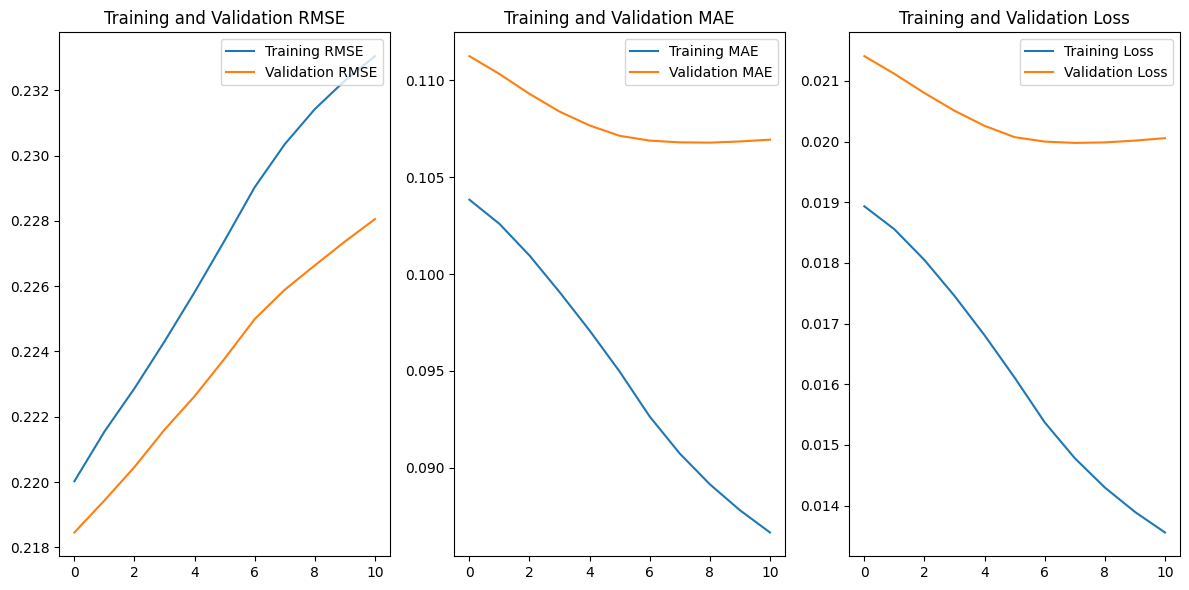

In [34]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [21]:
print("loss: " + str(loss))
print("val_loss: " + str(val_loss))
print("mae: " + str(mae))
print("val_mae: " + str(val_mae))
print("rmse: " + str(rmse))
print("val_rmse: " + str(val_rmse))

loss: [0.032706599682569504, 0.017891017720103264, 0.012432065792381763, 0.009750239551067352, 0.008487684652209282, 0.007704277988523245]
val_loss: [0.021597841754555702, 0.01862296275794506, 0.01929526962339878, 0.020019512623548508, 0.020703017711639404, 0.021233294159173965]
mae: [0.14197199046611786, 0.10071820020675659, 0.08375487476587296, 0.07384014874696732, 0.06852982938289642, 0.06495466083288193]
val_mae: [0.11193309724330902, 0.10284557938575745, 0.10494926571846008, 0.10679647326469421, 0.10844674706459045, 0.10978035628795624]
rmse: [0.1932096928358078, 0.2236929088830948, 0.2357235699892044, 0.24143347144126892, 0.24414516985416412, 0.2457457035779953]
val_rmse: [0.2156224548816681, 0.22335034608840942, 0.22963771224021912, 0.2330920249223709, 0.23544272780418396, 0.23728159070014954]


In [ ]:
"""
Extract weights from the model to use by recoomender function later
"""
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    return weights / np.linalg.norm(weights, axis=1, keepdims=True)

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

# **6. *Model Evaluation***

###Evaluation with Item Based Recommendation

In [ ]:
"""
Since the "item" refers to an anime movie, we need to set a threshold to recommend only those animes that have been rated by a minimum number of users.

Why? Setting a threshold ensures that the recommended animes have received enough ratings, reflecting a certain degree of popularity or user involvement.
"""

popularity_threshold = 50
df_anime_cleaned= df_anime_cleaned.query('Members >= @popularity_threshold')

In [ ]:
"""
Find the top-N similar animes based on cosine similarity of embeddings.

Args:
- name (str): Name of the anime to find similar animes for.
- n (int): Number of similar animes to return.
- return_dist (bool): If True, returns the distance array along with the similar animes.
- neg (bool): If True, returns the least similar animes. Defaults to False.

Returns:
- pd.DataFrame: A DataFrame containing the recommended animes along with similarity scores.
"""
def recommend_animes_by_name(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime.set_index('Name').loc[name]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]

        dists = np.dot(anime_weights, anime_weights[encoded_index])
        sorted_dists = np.argsort(dists)
        closest = sorted_dists[:n] if neg else sorted_dists[-n:]

        print(f'Animes closest to {name}')

        SimilarityArr = []
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]

            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name_to_use = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            synopsis = anime_frame['Synopsis'].values[0]
            similarity = f"{dists[close] * 100:.2f}%"

            SimilarityArr.append({"Name": name_to_use, "Similarity": similarity, "Genres": genre, "Synopsis": synopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]

    except KeyError:
        print(f'{name} not found in Anime list')

pd.set_option('display.max_colwidth', None)

In [ ]:
recommend_animes_by_name('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
3,Mushoku Tensei: Jobless Reincarnation Part 2,87.35%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
2,Made in Abyss: Dawn of the Deep Soul,63.67%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","After bonding over a tragic loss, the long-suffering Nanachi joins Riko and Reg on their journey into the depths of the Abyss. Awaiting the children is the Sea of Corpses—the Abyss's fifth layer, and the deepest level from which a traveler can return without losing their human form.\n\nThe masked sadist Bondrewd stands between the children and the rest of their adventure. Bondrewd's horrific laboratory serves as a final checkpoint for those wishing to traverse deeper into the Abyss, and the sociopathic scientist has no desire to allow Riko's party to pass through at no cost. Deeply scarred by Bondrewd's impact on their childhood, Nanachi is engulfed in turmoil over his resurgence in their life.\n\nBondrewd's only apparent weakness is Prushka, a brash child who claims to be his daughter. Riko, Reg, and Nanachi befriend Prushka and work with the girl to overcome her father's machinations and breach the Abyss's sixth layer."
1,[Oshi No Ko],63.28%,"Drama, Supernatural","In the entertainment world, celebrities often show exaggerated versions of themselves to the public, concealing their true thoughts and struggles beneath elaborate lies. Fans buy into these fabrications, showering their idols with undying love and support, until something breaks the illusion. Sixteen-year-old rising star Ai Hoshino of pop idol group B Komachi has the world captivated; however, when she announces a hiatus due to health concerns, the news causes many to become worried.\n\nAs a huge fan of Ai, gynecologist Gorou Amemiya cheers her on from his countryside medical practice, wishing he could meet her in person one day. His wish comes true when Ai shows up at his hospital—not sick, but pregnant with twins! While the doctor promises Ai to safely deliver her children, he wonders if this encounter with the idol will forever change the nature of his relationship with her."
0,No Game No Life: Zero,59.01%,"Drama, Fantasy, Romance","In ancient Disboard, Riku is an angry, young warrior intent on saving humanity from the warring Exceed, the 16 sentient species, fighting to establish the One True God among the Old Deus. In a lawless land, humanity's lack of magic and weak bodies have made them easy targets for the other Exceed, leaving the humans on the brink of extinction. \n\nOne day, however, hope returns to humanity when Riku finds a powerful female Ex-Machina, whom he names Schwi, in an abandoned elf city. Exiled from her Cluster because of her research into human emotions, Schwi is convinced that humanity has only survived due to the power of these feelings and is determined to understand the human heart. Forming an unlikely partnership in the midst of the overwhelming chaos, Riku and Schwi must now find the answers to their individual shortcomings in each other, and discover for themselves what it truly means to be human as they fight for their lives together against all odds. Each with a powerful new ally in tow, it is now up to them to prevent the extinction of the human rac

###Evaluation with User Based Recommendation

In [ ]:
"""
This function identifies users who are most similar to a given input user based on their anime preferences.
It computes the similarity using a weighted matrix and returns a DataFrame with the most similar users.
The function allows you to specify the number of similar users to find (`n`), and optionally return the similarity
distance or find the least similar users.

Parameters:
- item_input (int): User ID of the input user.
- n (int): Number of similar users to return (default is 10).
- return_dist (bool): If True, returns the similarity distance along with the results (default is False).
- neg (bool): If True, returns the least similar users (default is False).

Returns:
- pd.DataFrame: A DataFrame with similar users and their similarity scores, sorted by similarity.
"""
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        if item_input not in user_encoder.classes_:
            raise ValueError(f"{item_input} not found in User list")

        encoded_index = user_encoder.transform([item_input])[0]
        dists = np.dot(user_weights, user_weights[encoded_index])
        sorted_dists = np.argsort(dists)

        closest = sorted_dists[:n] if neg else sorted_dists[-n:]

        SimilarityArr = [{"similar_users": user_encoder.inverse_transform([close])[0], "similarity": dists[close]} for close in closest]

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

        return Frame

    except ValueError as ve:
        print(f'\033[1m{ve}\033[0m')
        return pd.DataFrame()  # Return empty DataFrame if the user is not found

In [ ]:
ratings_per_user = df_score_cleaned.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

similar_users = find_similar_users(random_user, n=2, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
0,452409,0.615552


In [ ]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
"""
This function retrieves a user's anime preferences by analyzing their top-rated animes.
It returns a DataFrame of these animes along with their genres, and optionally provides a word cloud visualization
of the genres they prefer.

Parameters:
- user_id (int): The ID of the user whose preferences are to be retrieved.
- plot (bool): If True, displays a word cloud visualization of the user's preferred genres (default is False).
- verbose (int): Controls the verbosity of the output. If non-zero, additional user details are printed (default is 0).

Returns:
- pd.DataFrame: A DataFrame containing the titles and genres of the top-rated animes watched by the user.
"""
def get_user_preferences(user_id, plot=False, verbose=0):
    # Filter animes watched by the user
    animes_watched_by_user = df_score_cleaned[df_score_cleaned['user_id'] == user_id]

    if animes_watched_by_user.empty:
        print(f"User #{user_id} has not watched any animes.")
        return pd.DataFrame()

    # Calculate the user's top-rated animes based on the 75th percentile rating
    user_rating_percentile = np.percentile(animes_watched_by_user['rating'], 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user['rating'] >= user_rating_percentile]

    # Sort and extract the top-rated anime IDs
    top_animes_user = animes_watched_by_user.sort_values(by="rating", ascending=False)['anime_id'].values

    # Retrieve anime details for the top-rated animes
    anime_df_rows = df_anime[df_anime['anime_id'].isin(top_animes_user)][['Name', 'Genres']]

    if verbose:
        avg_rating = animes_watched_by_user['rating'].mean()
        print(f"User \033[1m{user_id}\033[0m has watched {len(animes_watched_by_user)} anime(s) with an average rating of {avg_rating:.1f}/10\n")
        print('\033[1m----- Preferred genres----- \033[0m\n')

    # Plot the word cloud of genres if requested
    if plot:
        genres_list = [genre.strip() for genres in anime_df_rows['Genres'] if isinstance(genres, str) for genre in genres.split(',')]
        showWordCloud(dict(Counter(genres_list)))

    return anime_df_rows

User 636773 has watched 32 anime(s) with an average rating of 9.2/10

----- Preferred genres----- 



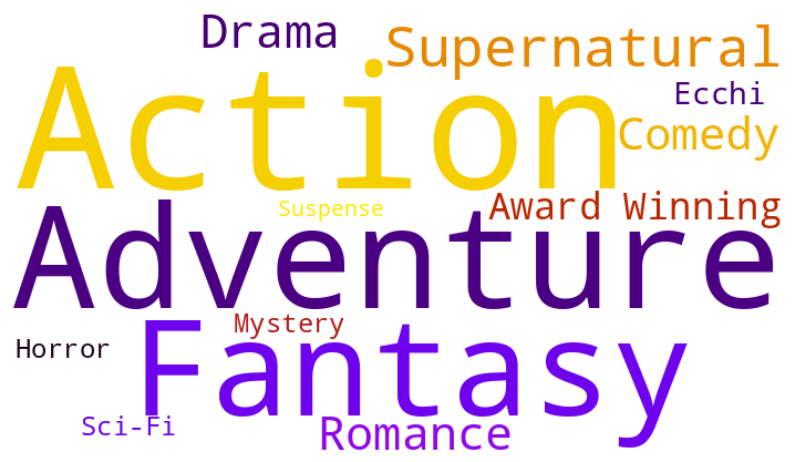

,Name,Genres
10,Naruto,"Action, Adventure, Fantasy"
53,Full Metal Panic! The Second Raid,Action
176,Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural"
202,Elfen Lied,"Action, Drama, Horror, Romance, Supernatural"
222,Groove Adventure Rave,"Adventure, Comedy, Fantasy, Romance"


In [ ]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

In [ ]:
"""
This function recommends anime titles to a selected user based on the preferences of users who are similar.
It filters out animes that the selected user has already watched and identifies new recommendations based on the preferences of similar users.

Parameters:
- similar_users (pd.DataFrame): DataFrame containing similar users to the selected user.
- user_pref (pd.DataFrame): DataFrame of the selected user's anime preferences.
- n (int): Number of anime recommendations to return (default is 5).

Returns:
- pd.DataFrame: A DataFrame containing the recommended animes along with their genres, synopsis, and the number of users who have watched them.
"""
def recommend_animes_by_user(similar_users, user_pref, n=5):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)

    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()

    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    anime_count = df_score_cleaned['anime_id'].value_counts()

    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)


In [ ]:
recommended_animes = recommend_animes_by_user(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 636773


,n,anime_name,Genres,Synopsis
0,11053,Eyeshield 21,Sports,"Shy, reserved, and small-statured, Deimon High School student Sena Kobayakawa is the perfect target for bullies. However, as a result of running errands throughout his life, Sena has become agile and developed a skill for avoiding crowds of people. After the cunning Youichi Hiruma—captain of the Deimon Devil Bats football team—witnesses Sena's rapid legs in motion, he coerces the timid boy into joining his squad.\n\nAs Hiruma wants to conceal Sena's identity from other clubs, Sena is forced to hide under the visored helmet of ""Eyeshield 21,"" a mysterious running back wearing the number 21 jersey. The legendary Eyeshield 21 can supposedly run at the speed of light and has achieved remarkable feats in the United States during his time at the Notre Dame College.\n\nAccustomed to avoiding his problems in the past, Sena's specialty might just help him become the new secret weapon of the Deimon Devil Bats. As he interacts with his teammates, Sena gradually gains more self-confidence and forges valuable bonds along the way."
1,11625,Tennis no Ouji-sama,Sports,"At the request of his father, tennis prodigy Ryouma Echizen has returned from America and is ready to take the Japanese tennis scene by storm. Aiming to become the best tennis player in the country, he enrolls in Seishun Academy—home to one of the best middle school tennis teams in Japan. \n\nAfter Ryouma catches the captain's eye, he finds himself playing for a spot on the starting lineup in the intra-school ranking matches despite only being a freshman. Due to his age, the rest of the Seishun Boys' Tennis Team are initially reluctant to accept him, but his skill and determination convinces them to let him in.\n\nArmed with their new ""super rookie,"" Seishun sets out to claim a spot in the National Tournament, hoping to take the coveted title for themselves. In order to do so, the team must qualify by playing through the Tokyo Prefectural and Kanto Regionals. Yet, the road ahead of them is shared by a plethora of strong schools, each playing tennis in unique ways for their own reasons. Ryouma and his teammates must learn to cooperate if they want to become the champions they aspire to be."
2,7068,Yakitate!! Japan,"Comedy, Gourmet","While countries such as France, England, and Germany all have their own internationally celebrated bread, Japan simply does not have one that can match in reputation.\n\nThus after discovering the wonders of breadmaking at a young age, Kazuma Azuma embarks on a quest to create Japan's own unique national bread. And being blessed with unusually warm hands that allow dough to ferment faster, Azuma is able to bring his baking innovations to another level.\n\nAs he begins working at the prestigious Japanese bakery chain, Pantasia, Azuma encounters other talented bakers and experiences firsthand the competitive world of baking. Along with his newfound friends and rivals, Azuma strives to create new and unparalleled bread that will start a baking revolution."
3,19020,Hajime no Ippo,Sports,"In his father's absence, teenager Ippo Makunouchi works hard to help his mother run her fishing boat rental business. Ippo's timid nature, his lack of sleep, and the sea smell make him an easy target for relentless bullies who leave him bruised and beaten on a daily basis. Mamoru Takamura, an up-and-coming boxer, rescues Ippo from a violent after-school incident and takes him back to the Kamogawa Boxing Gym for recovery. Takamura and his fellow boxers, Masaru Aoki and Tatsuya Kimura, are stunned by Ippo's powerful punches—a result of strong muscles developed through years serving his physically taxing family business. \n\nFollowing brief training under Takamura, Ippo impresses the other boxers in a practice match against prodigy Ichirou Miyata. He gains a rival in Miyata and a coach in Genji Kamogawa, the gym owner and a former boxer himself. As Ippo takes the first steps in his official boxing career, he fac